In [1]:
from collections import Counter
import pickle
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, auc, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
import matplotlib.gridspec as gridspec
%matplotlib notebook

In [ ]:
__author__ = 'Yazan Obeidi, yazan.obeidi@uwaterloo.ca'
__license__ = 'Apache v3'

In [43]:
data = pd.read_csv("data/creditcard.csv")

## 1. VISUALIZE THE DATA

In [ ]:
data.head()

In [ ]:
# plot the features (not amount or class)
plt.figure(figsize=(10,8))
for a in range(1, 29):
    plt.plot(data['V'+str(a)])
plt.legend(loc='best', fontsize=10, ncol=8)
plt.title("Plot of the first 28 columns (after PCA)")
plt.xlabel("Sample")

In [ ]:
data.Class.value_counts()

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))
ax1.hist(data.Time[data.Class == 1], bins = 50)
ax1.set_title('Fraud')
ax2.hist(data.Time[data.Class == 0], bins = 50)
ax2.set_title('Normal')
plt.xlabel('Time (s)')
plt.ylabel('Transactions')
plt.show()

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))
ax1.hist(data.Amount[data.Class == 1], bins = 30)
ax1.set_title('Fraud')
ax2.hist(data.Amount[data.Class == 0], bins = 30)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

In [ ]:
plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i in range(1, 29):
    ax = plt.subplot(gs[i-1])
    sns.distplot(data['V'+str(i)][data.Class == 1], bins=50)
    sns.distplot(data['V'+str(i)][data.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + 'V'+str(i))
plt.show()
plt.tight_layout()

In [4]:
# Based on observation of data overlap above, try out a second dataset with redunancies removed
clean_data = data.drop(['V28','V27','V23','V8'], axis =1)
# Later - can re run everything after running the following line
#data = clean_data

In [33]:
# Visualize the differences between 'data' and 'clean_data' using T-SNE

## 2. PREPARE DATASET

In [44]:
#Create dataframes of only Fraud and Normal transactions. Also Shuffle them.
fraud = shuffle(data[data.Class == 1])
normal = shuffle(data[data.Class == 0])
# Produce a training set of 80% of fraudulent and 80% normal transactions
X_train = fraud.sample(frac=0.8)
X_train = pd.concat([X_train, normal.sample(frac = 0.8)], axis = 0)
# Split remainder into testing and validation
remainder = data.loc[~data.index.isin(X_train.index)]
X_test = remainder.sample(frac=0.7)
X_validation = remainder.loc[~remainder.index.isin(X_test.index)]

In [45]:
# Resample the Training Data using ADASYN
# The test data remains imbalanced
#
#from imblearn.over_sampling import ADASYN
#ada = ADASYN()
#data_resampled, data_labels_resampled = ada.fit_sample(
#                  np.array(X_train.ix[:, X_train.columns != 'Class']), 
#                  np.array(X_train.Class))
# SLOW so will just unpickle something that was run previously
with open('pickle/train_data_resampled.pkl', 'rb') as f:
    X_train_resampled = pickle.load(f)
with open('pickle/train_data_labels_resampled.pkl', 'rb') as f:
    X_train_labels_resampled = pickle.load(f)
    
print(Counter(X_train_labels_resampled))
    
X_train_resampled = pd.DataFrame(X_train_resampled)
X_train_labels_resampled = pd.DataFrame(X_train_labels_resampled)
X_train_resampled = pd.concat([X_train_resampled, X_train_labels_resampled], axis=1)
X_train_resampled.columns = X_train.columns
X_train_resampled.head()

Counter({0: 227452, 1: 227324})


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,41233,-10.645800,5.918307,-11.671043,8.807369,-7.975501,-3.586806,-13.616797,6.428169,-7.368451,...,2.571970,0.206809,-1.667801,0.558419,-0.027898,0.354254,0.273329,-0.152908,0.00,1
1,53451,0.385108,1.217620,-1.953872,2.087076,-1.144225,-0.576888,-2.582865,0.643230,-1.191233,...,0.594623,0.372144,-0.310456,-0.624065,0.840216,-0.159452,0.599482,0.288916,8.00,1
2,26556,-19.179826,11.817922,-21.919174,6.086236,-14.708845,-4.308888,-15.357952,12.857165,-3.999861,...,1.746802,-1.353149,-0.762965,0.117028,1.297994,-0.224825,1.621052,0.484614,99.99,1
3,102489,-2.296987,4.064043,-5.957706,4.680008,-2.080938,-1.463272,-4.490847,1.029246,-1.593249,...,1.089084,0.975398,-0.625530,-0.535181,0.247435,0.160400,0.969582,0.335041,104.00,1
4,154493,-7.381547,-7.449015,-4.696287,3.728439,6.198304,-6.406267,-5.831452,1.457175,-0.646203,...,1.176575,-0.978692,-0.278330,-0.635874,0.123539,0.404729,0.704915,-1.229992,35.00,1


In [46]:
# Shuffle the datasets once more to ensure random feeding into the classification algorithms
X_train = shuffle(X_train)
X_test = shuffle(X_test)
X_validation = shuffle(X_validation)
X_train_ = shuffle(X_train_resampled)
X_test_ = shuffle(X_test)
X_validation_ = shuffle(X_validation)
data_resampled = pd.concat([X_train_, X_test_, X_validation_])

In [47]:
# Normalize the data to an average of 0 and std of 1, but do not touch the Class column
for feature in X_train.columns.values[:-1]:
    mean, std = data[feature].mean(), data[feature].std()
    X_train.loc[:, feature] = (X_train[feature] - mean) / std
    X_test.loc[:, feature] = (X_test[feature] - mean) / std
    X_validation.loc[:, feature] = (X_validation[feature] - mean) / std
for feature in X_train_.columns.values[:-1]:
    mean, std = data_resampled[feature].mean(), data_resampled[feature].std()
    X_train_.loc[:, feature] = (X_train_[feature] - mean) / std
    X_test_.loc[:, feature] = (X_test_[feature] - mean) / std
    X_validation_.loc[:, feature] = (X_validation_[feature] - mean) / std

In [48]:
# Create labels
y_train = X_train.Class
y_test = X_test.Class
y_validation = X_validation.Class
y_train_ = X_train_.Class
y_test_ = X_test_.Class
y_validation_ = X_validation_.Class
# Remove labels from X's
X_train = X_train.drop(['Class'], axis=1)
X_train_ = X_train_.drop(['Class'], axis=1)
X_test = X_test.drop(['Class'], axis=1)
X_test_ = X_test_.drop(['Class'], axis=1)
X_validation = X_validation.drop(['Class'], axis=1)
X_validation_ = X_validation_.drop(['Class'], axis=1)

In [49]:
# Pickle and save the dataset
dataset = {'X_train' : X_train,
           'X_train_': X_train_,
           'X_test': X_test,
           'X_test_': X_test,
           'X_validation': X_validation,
           'X_validation_': X_validation_,
           'y_train': y_train,
           'y_train_': y_train_,
           'y_test': y_test,
           'y_test_': y_test_,
           'y_validation': y_validation,
           'y_validation_': y_validation_}
with open('pickle/data_with_resample_apr19.pkl', 'wb+') as f:
    pickle.dump(dataset, f)

In [3]:
# Load pickled Dataset:
with open('pickle/data_with_resample_apr19.pkl', 'rb+') as f:
    dataset = pickle.load(f)

In [3]:
# At this point we have our data split into Training, Testing and Validation, and have a mirror dataset with 
# features visually identified as redundant removed for comparison
#
# TRY:
# Linear SVM
# Random Forest
# MLP

In [4]:
# First see that unbalance is corrected
for k, v in dataset.iteritems():
    if 'y' in k:
        print(k, Counter(v))

('y_train_', Counter({0: 227452, 1: 227324}))
('y_validation', Counter({0: 17058, 1: 30}))
('y_test_', Counter({0: 39805, 1: 68}))
('y_train', Counter({0: 227452, 1: 394}))
('y_validation_', Counter({0: 17058, 1: 30}))
('y_test', Counter({0: 39805, 1: 68}))


In [6]:
def plot_confusion_matrix(y_test, pred):
    
    y_test_legit = y_test.value_counts()[0]
    y_test_fraud = y_test.value_counts()[1]
    
    cfn_matrix = confusion_matrix(y_test, pred)
    cfn_norm_matrix = np.array([[1.0 / y_test_legit,1.0/y_test_legit],[1.0/y_test_fraud,1.0/y_test_fraud]])
    norm_cfn_matrix = cfn_matrix * cfn_norm_matrix

    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(1,2,1)
    sns.heatmap(cfn_matrix,cmap='coolwarm_r',linewidths=0.5,annot=True,ax=ax)
    plt.title('Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')

    ax = fig.add_subplot(1,2,2)
    sns.heatmap(norm_cfn_matrix,cmap='coolwarm_r',linewidths=0.5,annot=True,ax=ax)

    plt.title('Normalized Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()
    
    print('---Classification Report---')
    print(classification_report(y_test,pred))

# 3. MACHINE LEARNING

## a) SUPPORT VECTOR MACHINE

<IPython.core.display.Javascript object>


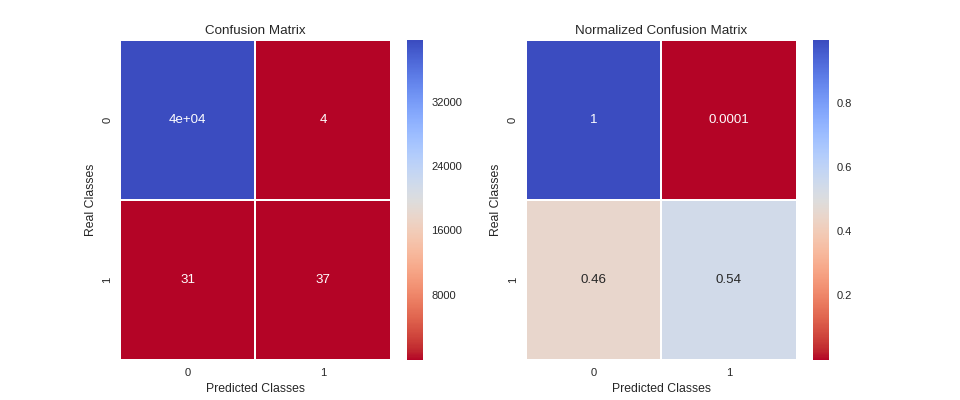

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     39805
          1       0.90      0.54      0.68        68

avg / total       1.00      1.00      1.00     39873



In [6]:
# Linear SVM on unsampled training data
lsvm = svm.LinearSVC(C=1.0, dual=False)
lsvm.fit(dataset['X_train'], dataset['y_train'])
y_pred = lsvm.predict(dataset['X_test'])
plot_confusion_matrix(dataset['y_test'], y_pred)

<IPython.core.display.Javascript object>


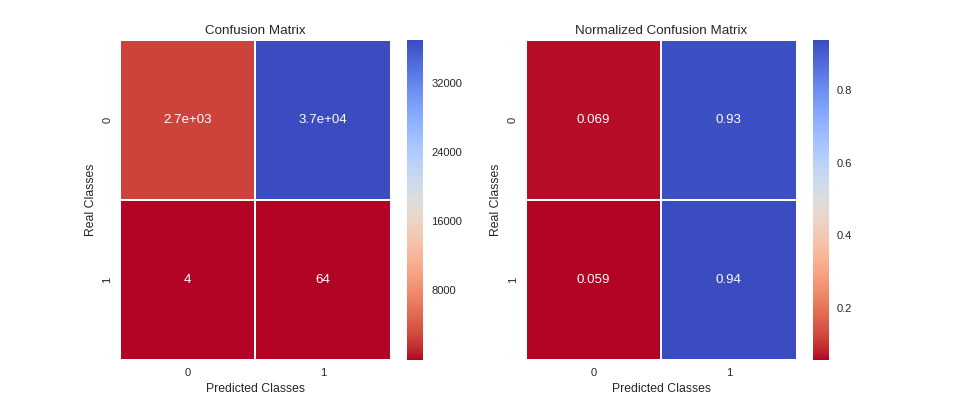

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      0.07      0.13     39805
          1       0.00      0.94      0.00        68

avg / total       1.00      0.07      0.13     39873



In [15]:
# Linear SVM on ADASYN training data #svm_adasyn_unweighted_c0_01
lsvm = svm.LinearSVC(C=1, dual=False)
lsvm.fit(dataset['X_train_'], dataset['y_train_'])
y_pred = lsvm.predict(dataset['X_test_'])
plot_confusion_matrix(dataset['y_test_'], y_pred)

<IPython.core.display.Javascript object>


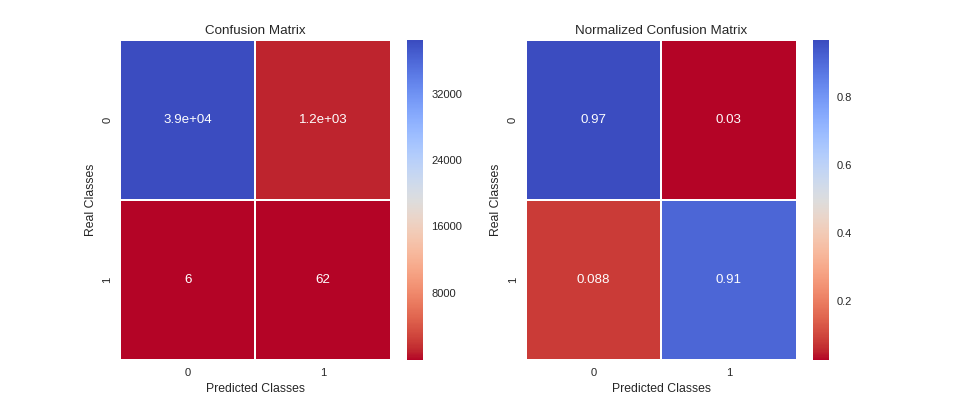

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      0.97      0.98     39805
          1       0.05      0.91      0.09        68

avg / total       1.00      0.97      0.98     39873



In [25]:
# Linear SVM on WEIGHTED unsampled training data
lsvm = svm.LinearSVC(C=1.0, dual=False, class_weight={1:1000,0:1})
lsvm.fit(dataset['X_train'], dataset['y_train'])
y_pred = lsvm.predict(dataset['X_test'])
plot_confusion_matrix(dataset['y_test'], y_pred)

### SVM PRECISION RECALL CURVE

<IPython.core.display.Javascript object>


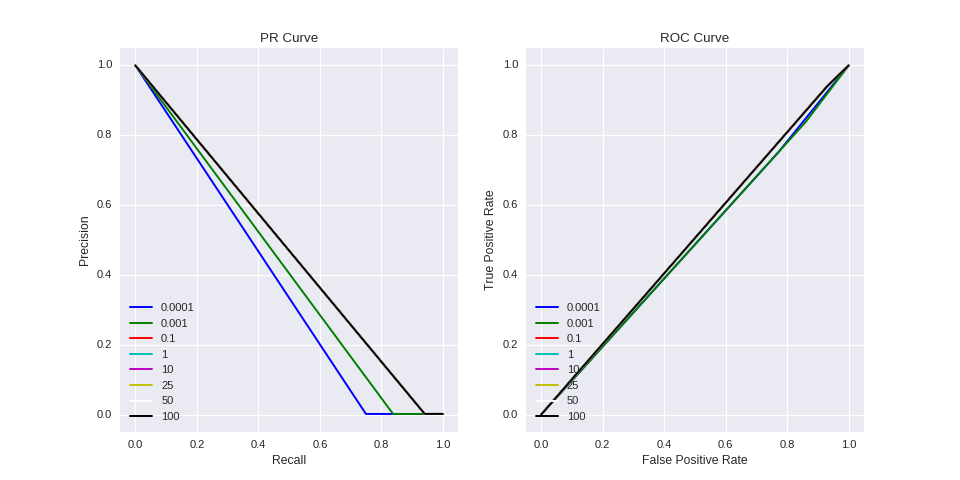

In [28]:
# Not ready to give up on ADASYN, try finding the best C value
# svm_prec_recal_adasyn_different_c
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for c,k in zip([0.0001, 0.001, 0.1, 1, 10, 25, 50, 100],'bgrcmywk'):
    lsvm_ = svm.LinearSVC(C=c, dual=False, class_weight={1:1,0:1})
    lsvm_.fit(dataset['X_train_'], dataset['y_train_'])
    y_pred = lsvm_.predict(dataset['X_test_'])

    p,r,_ = precision_recall_curve(dataset['y_test_'], y_pred)
    tpr,fpr,_ = roc_curve(dataset['y_test_'], y_pred)
    
    ax1.plot(r,p,c=k,label=c)
    ax2.plot(tpr,fpr,c=k,label=c)

ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')
plt.show()
# Conclusion: c > 0.1 is best

<IPython.core.display.Javascript object>


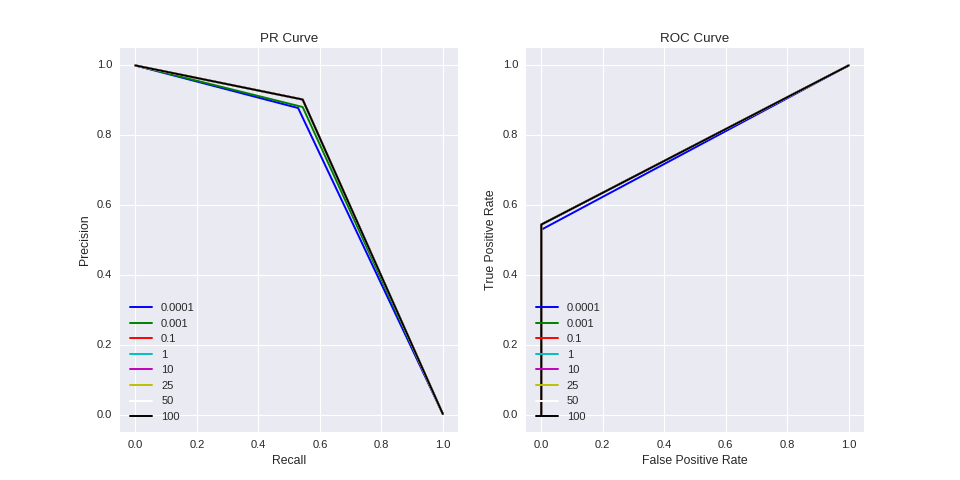

0.0001
0.001
0.1
1
10
25
50
100


In [4]:
# Same as above but with unsampled data
# svm_prec_recal_unsampled_unweighted_different_c
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for c,k in zip([0.0001, 0.001, 0.1, 1, 10, 25, 50, 100],'bgrcmywk'):
    print(c)
    lsvm_ = svm.LinearSVC(C=c, dual=False, class_weight={1:1,0:1})
    lsvm_.fit(dataset['X_train'], dataset['y_train'])
    y_pred = lsvm_.predict(dataset['X_test'])

    p,r,_ = precision_recall_curve(dataset['y_test'], y_pred)
    tpr,fpr,_ = roc_curve(dataset['y_test'], y_pred)
    
    ax1.plot(r,p,c=k,label=c)
    ax2.plot(tpr,fpr,c=k,label=c)

ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')
plt.show()
# Conclusion: c > 0.1 is best

<IPython.core.display.Javascript object>


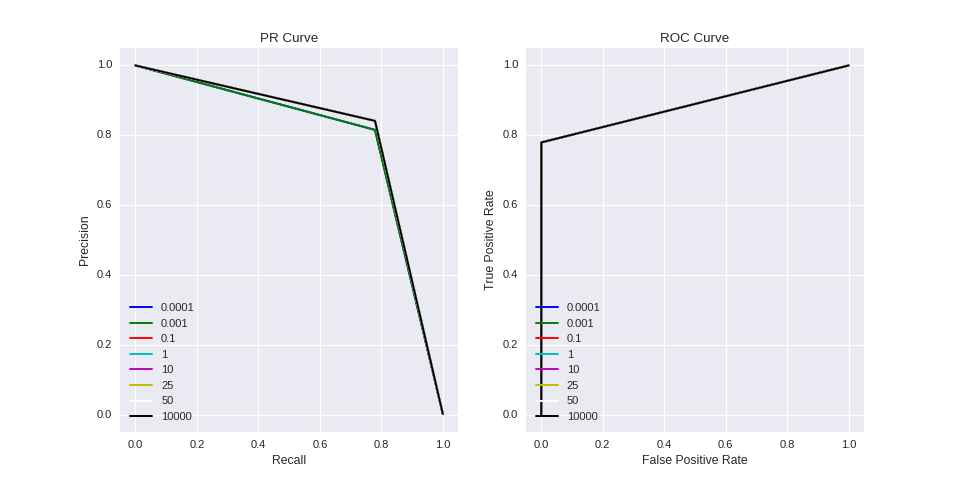

In [26]:
# EXPLORE C VALUE with the WEIGHTED unsampled training data
# svm_prec_recal_weighted_unsampled_different_c
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for c,k in zip([0.0001, 0.001, 0.1, 1, 10, 25, 50, 10000],'bgrcmywk'):
    lsvm_ = svm.LinearSVC(C=c, dual=False, class_weight={1:10,0:1})
    lsvm_.fit(dataset['X_train'], dataset['y_train'])
    y_pred = lsvm_.predict(dataset['X_test'])

    p,r,_ = precision_recall_curve(dataset['y_test'], y_pred)
    tpr,fpr,_ = roc_curve(dataset['y_test'], y_pred)
    
    ax1.plot(r,p,c=k,label=c)
    ax2.plot(tpr,fpr,c=k,label=c)
    
ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')
plt.show()
# CONCLUSION: c > 0.001 is best

<IPython.core.display.Javascript object>


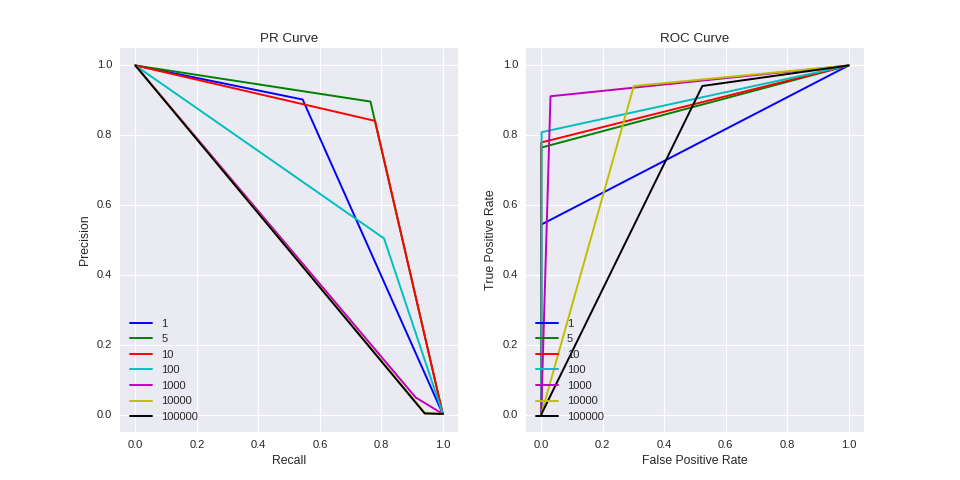

In [14]:
# EXPLORE "class_weight" with c=0.01 since according to above, does not matter. On unsampled data
# Note w=1 is the same as unweighted unsampled training data
#svm_prec_recal_unsampled_different_weights_c_1
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for w,k in zip([1, 5, 10, 100, 1000, 10000, 100000],'bgrcmyk'):
    lsvm_ = svm.LinearSVC(C=1, dual=False, class_weight={1:w,0:1})
    lsvm_.fit(dataset['X_train'], dataset['y_train'])
    y_pred = lsvm_.predict(dataset['X_test'])

    p,r,_ = precision_recall_curve(dataset['y_test'], y_pred, pos_label=1)
    tpr,fpr,_ = roc_curve(dataset['y_test'], y_pred)
    
    ax1.plot(r,p,c=k,label=w)
    ax2.plot(tpr,fpr,c=k,label=w)
    
ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')
plt.show()
# Conclusion: weight of 5 for the minority class works best.
# Note: setting c=1 or c=100 produces the same plots.

<IPython.core.display.Javascript object>


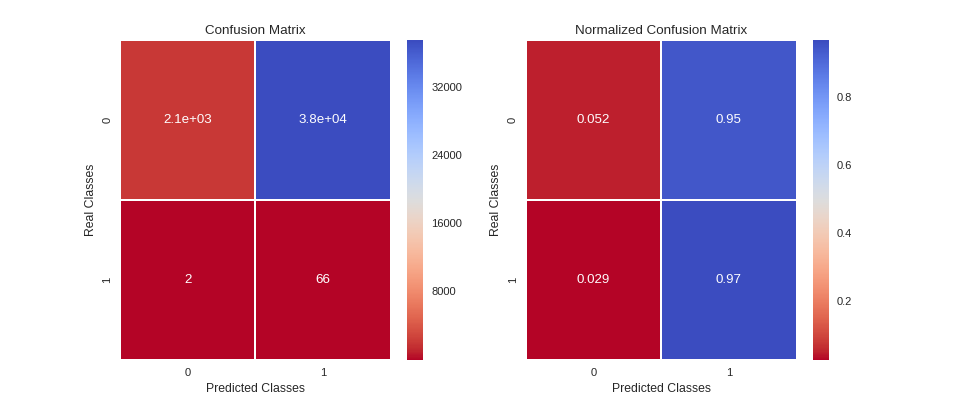

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      0.05      0.10     39805
          1       0.00      0.97      0.00        68

avg / total       1.00      0.05      0.10     39873



<IPython.core.display.Javascript object>


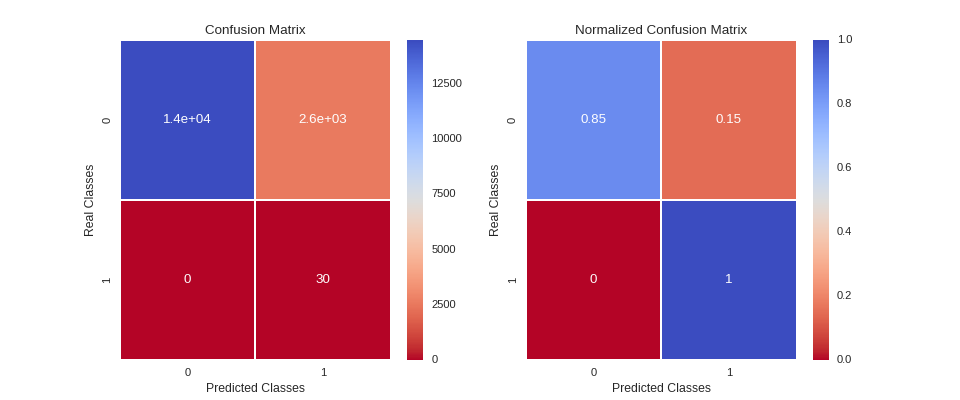

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      0.85      0.92     17058
          1       0.01      1.00      0.02        30

avg / total       1.00      0.85      0.92     17088



In [18]:
# Linear SVM on WEIGHTED ADASYN training data with minority class weight of 10
# svm_adasyn_c_1_weight_10
lsvm = svm.LinearSVC(C=1, dual=False, class_weight={1:10,0:1})
lsvm.fit(dataset['X_train_'], dataset['y_train_'])
y_pred = lsvm.predict(dataset['X_test_'])
y_pred_validation = lsvm.predict(dataset['X_validation_'])
plot_confusion_matrix(dataset['y_test_'], y_pred)
plot_confusion_matrix(dataset['y_validation_'], y_pred_validation)
# Conclusion: no bueno.

<IPython.core.display.Javascript object>


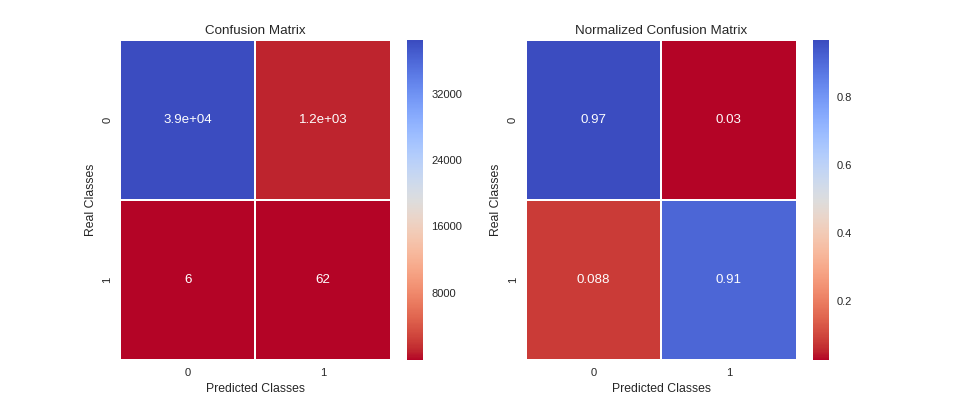

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      0.97      0.98     39805
          1       0.05      0.91      0.09        68

avg / total       1.00      0.97      0.98     39873



<IPython.core.display.Javascript object>


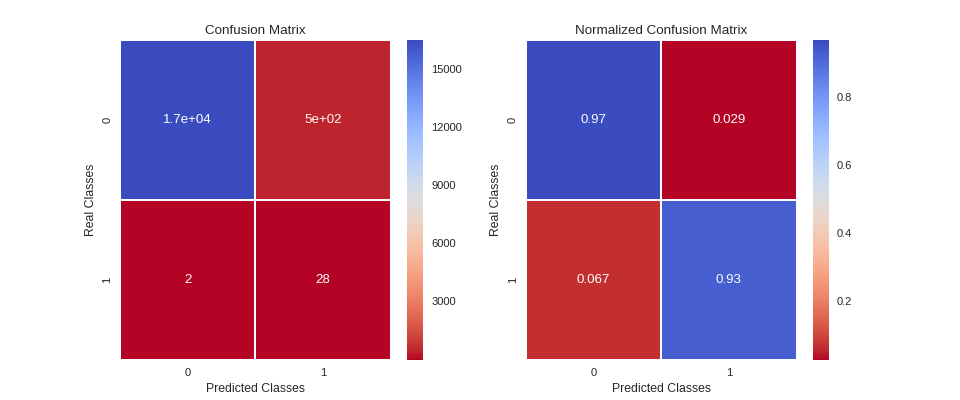

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      0.97      0.98     17058
          1       0.05      0.93      0.10        30

avg / total       1.00      0.97      0.98     17088



In [7]:
# Linear SVM on WEIGHTED unsampled training data with minority class weight of 1000
lsvm = svm.LinearSVC(C=1, dual=False, class_weight={1:1000,0:1})
lsvm.fit(dataset['X_train'], dataset['y_train'])
y_pred = lsvm.predict(dataset['X_test'])
y_pred_validation = lsvm.predict(dataset['X_validation'])
plot_confusion_matrix(dataset['y_test'], y_pred)
plot_confusion_matrix(dataset['y_validation'], y_pred_validation)

fitting
predicting test
predicting validation


<IPython.core.display.Javascript object>


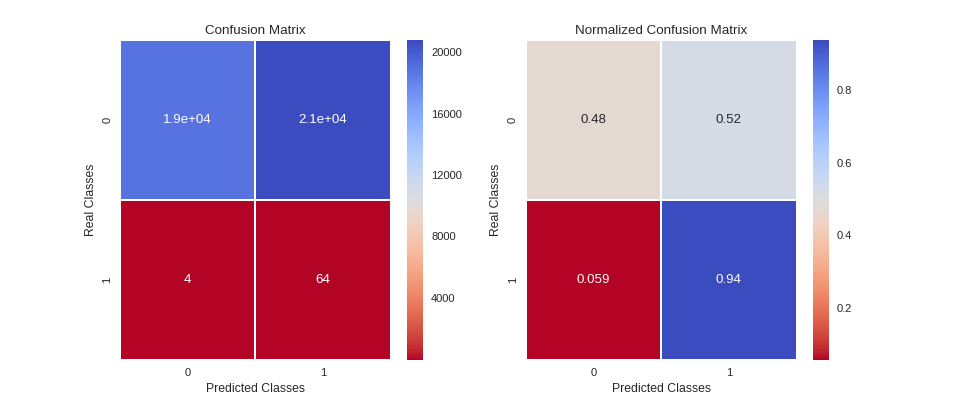

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      0.48      0.64     39805
          1       0.00      0.94      0.01        68

avg / total       1.00      0.48      0.64     39873



<IPython.core.display.Javascript object>


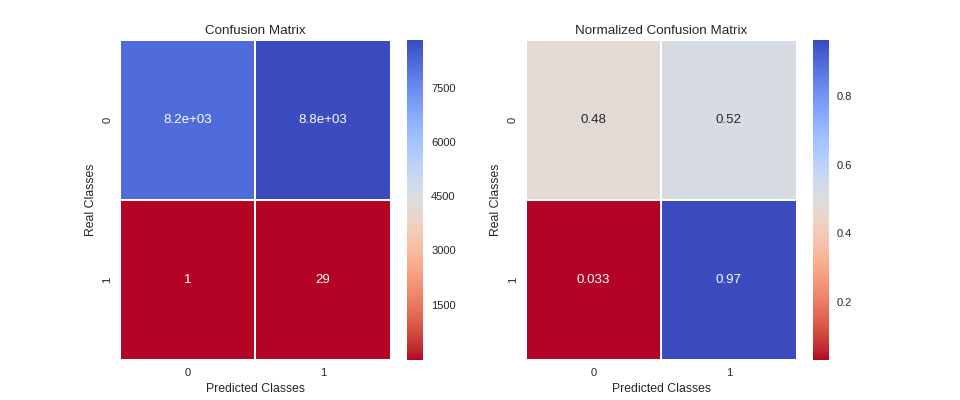

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      0.48      0.65     17058
          1       0.00      0.97      0.01        30

avg / total       1.00      0.48      0.65     17088



In [10]:
# Linear SVM on WEIGHTED unsampled training data with minority class weight of 100000
lsvm = svm.LinearSVC(C=1, dual=False, class_weight={1:100000,0:1})
print('fitting')
lsvm.fit(dataset['X_train'], dataset['y_train'])
print('predicting test')
y_pred = lsvm.predict(dataset['X_test'])
print('predicting validation')
y_pred_validation = lsvm.predict(dataset['X_validation'])
plot_confusion_matrix(dataset['y_test'], y_pred)
plot_confusion_matrix(dataset['y_validation'], y_pred_validation)
# Conclusion: clearly too high of a minority class weight - compromising TP rate.

## b) RANDOM FOREST

<IPython.core.display.Javascript object>


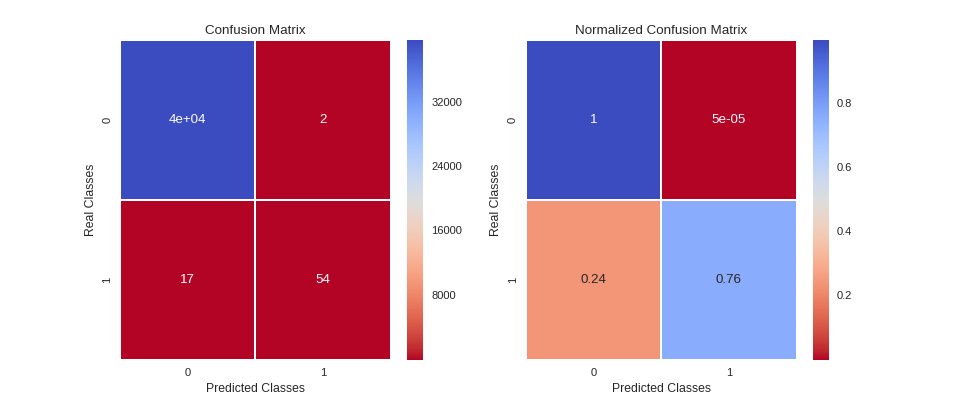

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     39802
          1       0.96      0.76      0.85        71

avg / total       1.00      1.00      1.00     39873



In [37]:
# Random Forest on unsampled training data
# rf_n_est_100_unsampled_unweighted
rf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=4)
rf.fit(dataset['X_train'], dataset['y_train'])
y_pred = rf.predict(dataset['X_test'])
plot_confusion_matrix(dataset['y_test'], y_pred)

<IPython.core.display.Javascript object>


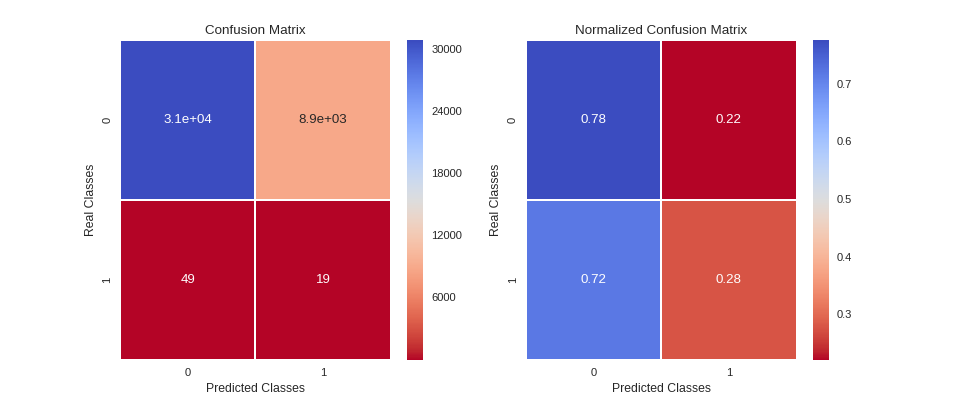

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      0.78      0.87     39805
          1       0.00      0.28      0.00        68

avg / total       1.00      0.78      0.87     39873



In [17]:
# Random Forest on ADASYN training data
rf_adasyn = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=4)
rf_adasyn.fit(dataset['X_train_'], dataset['y_train_'])
y_pred = rf_adasyn.predict(dataset['X_test_'])
plot_confusion_matrix(dataset['y_test_'], y_pred)

<IPython.core.display.Javascript object>


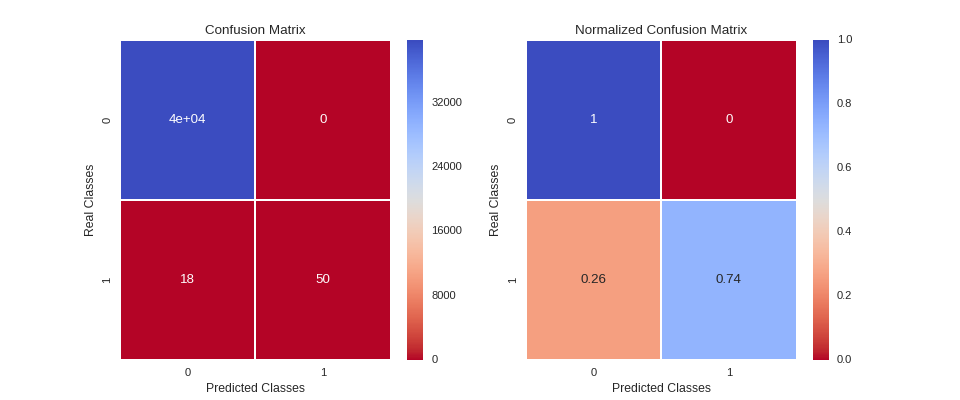

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     39805
          1       1.00      0.74      0.85        68

avg / total       1.00      1.00      1.00     39873



In [16]:
# Random Forest on WEIGHTED unsampled training data
rf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=4, class_weight={1:10,0:1})
rf.fit(dataset['X_train'], dataset['y_train'])
y_pred = rf.predict(dataset['X_test'])
plot_confusion_matrix(dataset['y_test'], y_pred)

### PRECISION RECALL CURVES

<IPython.core.display.Javascript object>


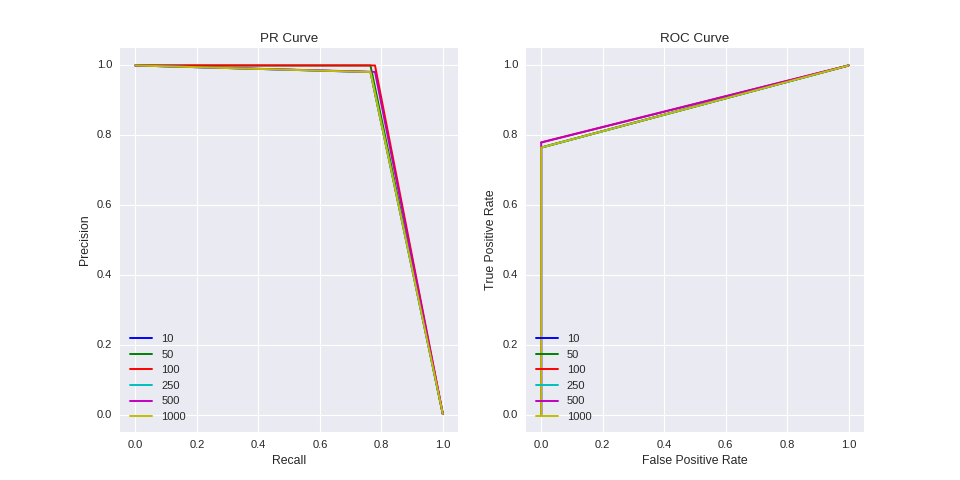

10
50
100
250
500
1000


In [15]:
# Unsampled training data # rf_prec_recall_n_est_unsampled_unweighted
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for n_est,k in zip([10, 50, 100, 250, 500, 1000],'bgrcmy'):
    print(n_est)
    rf = RandomForestClassifier(n_estimators=n_est, bootstrap=False, max_features=0.33, n_jobs=4)
    rf.fit(dataset['X_train'], dataset['y_train'])
    y_pred = rf.predict(dataset['X_test'])

    p,r,_ = precision_recall_curve(dataset['y_test'], y_pred)
    tpr,fpr,_ = roc_curve(dataset['y_test'], y_pred)
    
    ax1.plot(r,p,c=k,label=n_est)
    ax2.plot(tpr,fpr,c=k,label=n_est)

ax1.legend(loc='lower left')
ax2.legend(loc='lower left')
plt.show()
# Conclusion: n_estimators=100 is best

<IPython.core.display.Javascript object>


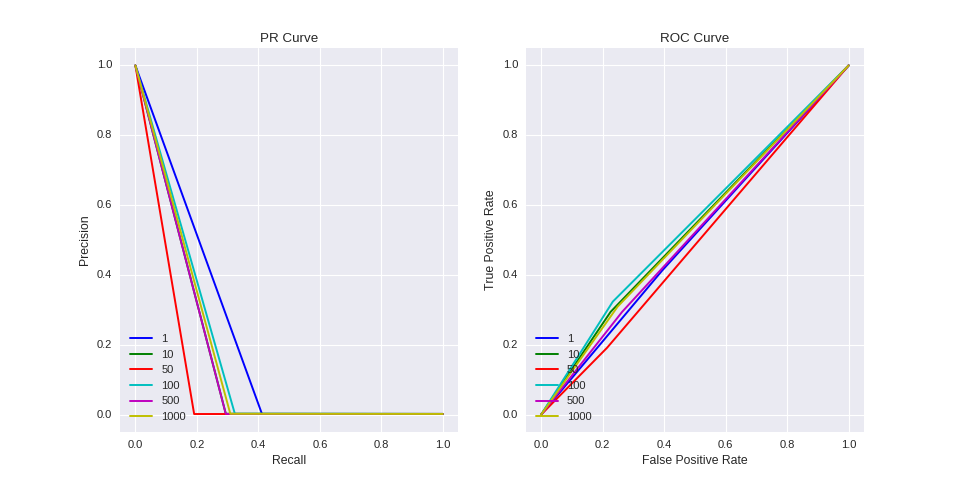

/home/yazan/.venvs/syde522/local/lib/python2.7/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


In [12]:
# Not ready to give up on ADASYN, try finding the best C value #rf_prec_recall_n_est_adasyn_unweighted
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for n_est,k in zip([1, 10, 50, 100, 500, 1000],'bgrcmy'):
    rf_adasyn_ = RandomForestClassifier(n_estimators=n_est, oob_score=True, n_jobs=4)
    rf_adasyn_.fit(dataset['X_train_'], dataset['y_train_'])
    y_pred = rf_adasyn_.predict(dataset['X_test_'])

    p,r,_ = precision_recall_curve(dataset['y_test_'], y_pred)
    tpr,fpr,_ = roc_curve(dataset['y_test_'], y_pred)
    
    ax1.plot(r,p,c=k,label=n_est)
    ax2.plot(tpr,fpr,c=k,label=n_est)

ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')
plt.show()
# Conclusion:

<IPython.core.display.Javascript object>


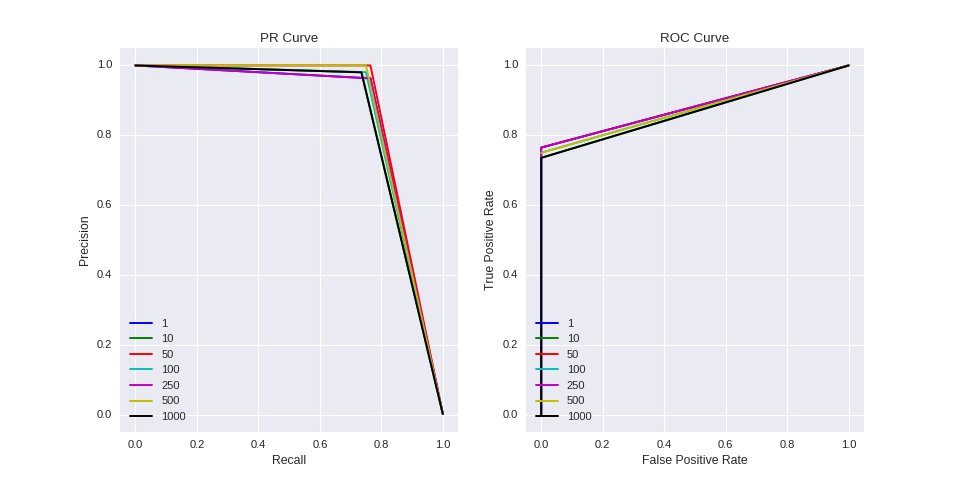

1
10
50
100
250
500
1000


In [17]:
# Unsampled training data, WEIGHTED - explore different weights
# rf_prec_recall_n_est_unsampled_n_est_100_different_weights
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for w,k in zip([1, 10, 50, 100, 250, 500, 1000],'bgrcmyk'):
    print(w)
    rf = RandomForestClassifier(n_estimators=100, bootstrap=False, 
                                max_features=0.33, n_jobs=4, 
                                class_weight={1:w,0:1})
    rf.fit(dataset['X_train'], dataset['y_train'])
    y_pred = rf.predict(dataset['X_test'])

    p,r,_ = precision_recall_curve(dataset['y_test'], y_pred)
    tpr,fpr,_ = roc_curve(dataset['y_test'], y_pred)
    
    ax1.plot(r,p,c=k,label=w)
    ax2.plot(tpr,fpr,c=k,label=w)

ax1.legend(loc='lower left')
ax2.legend(loc='lower left')
plt.show()
# Conclusion: 50 works best

## c) MULTI-LAYER PERCEPTRON

Iteration 1, loss = 0.00580708
Iteration 2, loss = 0.00290610
Iteration 3, loss = 0.00264700
Iteration 4, loss = 0.00251043
Iteration 5, loss = 0.00240242
Iteration 6, loss = 0.00225784
Iteration 7, loss = 0.00220368
Iteration 8, loss = 0.00216249
Iteration 9, loss = 0.00204695
Iteration 10, loss = 0.00202412
Iteration 11, loss = 0.00196967
Iteration 12, loss = 0.00189707
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Setting learning rate to 0.020000
Iteration 13, loss = 0.00170818
Iteration 14, loss = 0.00166501
Iteration 15, loss = 0.00164642
Iteration 16, loss = 0.00163065
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Setting learning rate to 0.004000
Iteration 17, loss = 0.00158794
Iteration 18, loss = 0.00158033
Iteration 19, loss = 0.00157644
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Setting learning rate to 0.000800
Iteration 20, loss = 0.00156619
Iteration 21, loss = 0.0

<IPython.core.display.Javascript object>


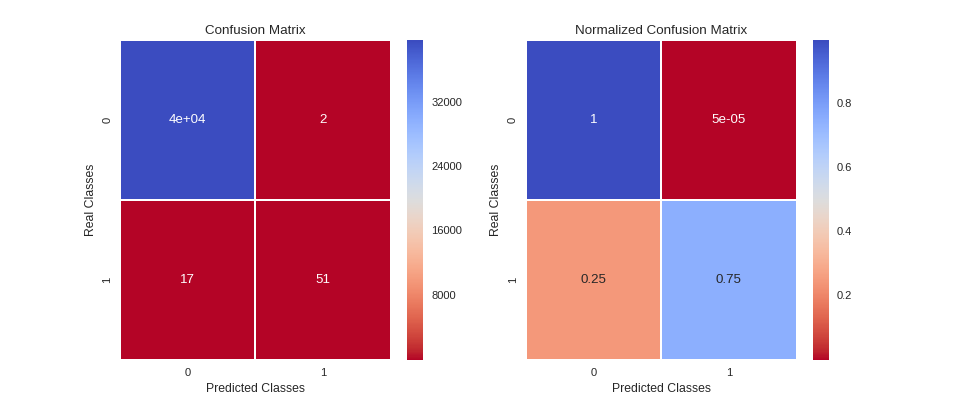

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     39805
          1       0.96      0.75      0.84        68

avg / total       1.00      1.00      1.00     39873



In [21]:
# MLP on unsampled training data
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=50,
                    solver='sgd', verbose=10, tol=1e-4, momentum=0.9,
                    learning_rate='adaptive', learning_rate_init=0.1)
mlp.fit(dataset['X_train'], dataset['y_train'])
y_pred = mlp.predict(dataset['X_test'])
plot_confusion_matrix(dataset['y_test'], y_pred)

Iteration 1, loss = 0.02955043
Iteration 2, loss = 0.00334991
Iteration 3, loss = 0.00279688
Iteration 4, loss = 0.00254439
Iteration 5, loss = 0.00235930
Iteration 6, loss = 0.00228663
Iteration 7, loss = 0.00214945
Iteration 8, loss = 0.00208838
Iteration 9, loss = 0.00199293
Iteration 10, loss = 0.00188649
Iteration 11, loss = 0.00188327
Iteration 12, loss = 0.00178455
Iteration 13, loss = 0.00169517
Iteration 14, loss = 0.00163943
Iteration 15, loss = 0.00161802
Iteration 16, loss = 0.00151716
Iteration 17, loss = 0.00150037
Iteration 18, loss = 0.00144918
Iteration 19, loss = 0.00143278
Iteration 20, loss = 0.00129247
Iteration 21, loss = 0.00130595
Iteration 22, loss = 0.00124852
Iteration 23, loss = 0.00125089
Iteration 24, loss = 0.00120472
Iteration 25, loss = 0.00121763
Iteration 26, loss = 0.00112522
Iteration 27, loss = 0.00107958
Iteration 28, loss = 0.00101999
Iteration 29, loss = 0.00102336
Iteration 30, loss = 0.00102903
Iteration 31, loss = 0.00095967
Iteration 32, los

<IPython.core.display.Javascript object>


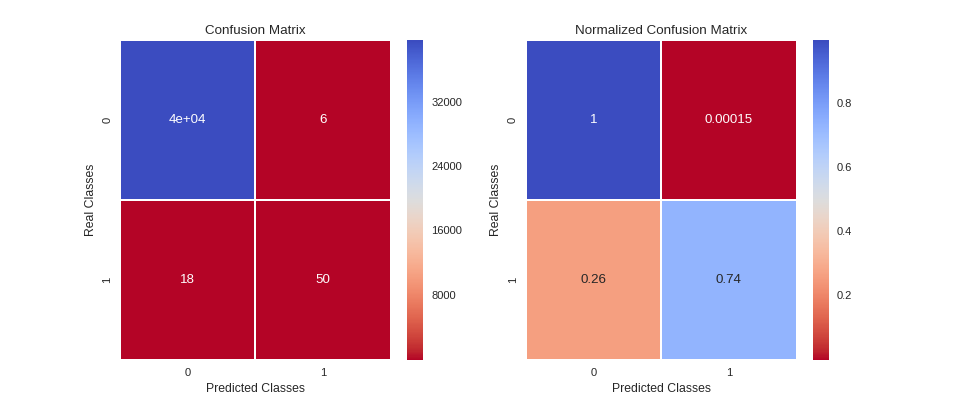

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     39805
          1       0.89      0.74      0.81        68

avg / total       1.00      1.00      1.00     39873



In [20]:
# MLP on unsampled training data
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=50,
                    solver='adam', verbose=10, tol=1e-6, momentum=0.9,
                    learning_rate='adaptive', learning_rate_init=0.001)
mlp.fit(dataset['X_train'], dataset['y_train'])
y_pred = mlp.predict(dataset['X_test'])
plot_confusion_matrix(dataset['y_test'], y_pred)

Iteration 1, loss = 0.08038942
Iteration 2, loss = 0.02789200
Iteration 3, loss = 0.01559238
Iteration 4, loss = 0.01003204
Iteration 5, loss = 0.00724619
Iteration 6, loss = 0.00571669
Iteration 7, loss = 0.00464596
Iteration 8, loss = 0.00391831
Iteration 9, loss = 0.00338153
Iteration 10, loss = 0.00295182
Iteration 11, loss = 0.00274460
Iteration 12, loss = 0.00238533
Iteration 13, loss = 0.00237201
Iteration 14, loss = 0.00205979
Iteration 15, loss = 0.00196707
Iteration 16, loss = 0.00186946
Iteration 17, loss = 0.00173432
Iteration 18, loss = 0.00157233
Iteration 19, loss = 0.00149745
Iteration 20, loss = 0.00151923
Iteration 21, loss = 0.00132686
Iteration 22, loss = 0.00132568
Iteration 23, loss = 0.00124286
Iteration 24, loss = 0.00118017
Iteration 25, loss = 0.00126700
Iteration 26, loss = 0.00108808
Iteration 27, loss = 0.00116161
Iteration 28, loss = 0.00105346
Iteration 29, loss = 0.00103113
Iteration 30, loss = 0.00105402
Iteration 31, loss = 0.00109298
Iteration 32, los

<IPython.core.display.Javascript object>


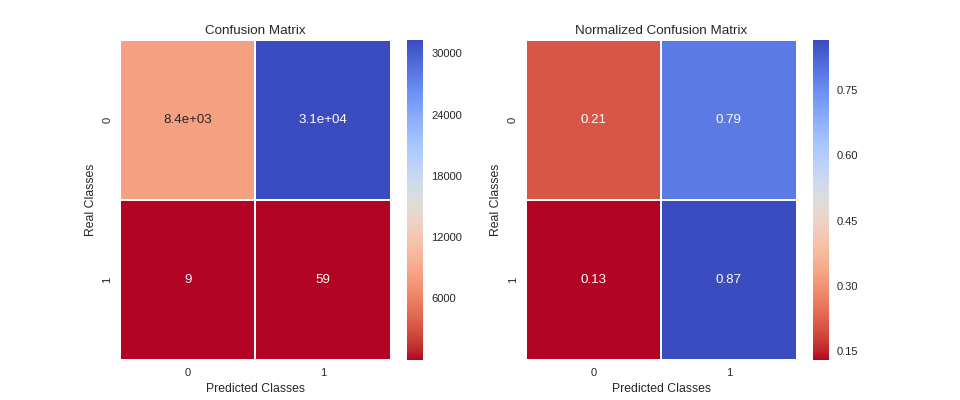

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      0.21      0.35     39805
          1       0.00      0.87      0.00        68

avg / total       1.00      0.21      0.35     39873



In [18]:
# MLP on ADASYN training data, ADAM optimizer
mlp_adasyn = MLPClassifier(hidden_layer_sizes=(100,), max_iter=50,
                    solver='adam', verbose=10, tol=1e-6, momentum=0.9,
                    learning_rate='adaptive', learning_rate_init=0.001)
mlp_adasyn.fit(dataset['X_train_'], dataset['y_train_'])
y_pred = mlp_adasyn.predict(dataset['X_test_'])
plot_confusion_matrix(dataset['y_test_'], y_pred)

Iteration 1, loss = 0.03798914
Iteration 2, loss = 0.01263377
Iteration 3, loss = 0.00812900
Iteration 4, loss = 0.00586469
Iteration 5, loss = 0.00480351
Iteration 6, loss = 0.00380565
Iteration 7, loss = 0.00313822
Iteration 8, loss = 0.00283368
Iteration 9, loss = 0.00236959
Iteration 10, loss = 0.00225508
Iteration 11, loss = 0.00205706
Iteration 12, loss = 0.00189003
Iteration 13, loss = 0.00200898
Iteration 14, loss = 0.00203984
Iteration 15, loss = 0.00216966
Training loss did not improve more than tol=0.000001 for two consecutive epochs. Setting learning rate to 0.020000
Iteration 16, loss = 0.00126276
Iteration 17, loss = 0.00116946
Iteration 18, loss = 0.00114439
Iteration 19, loss = 0.00112472
Iteration 20, loss = 0.00111207
Iteration 21, loss = 0.00109499
Iteration 22, loss = 0.00107555
Iteration 23, loss = 0.00105597
Iteration 24, loss = 0.00104942
Iteration 25, loss = 0.00103430
Iteration 26, loss = 0.00102787
Iteration 27, loss = 0.00101219
Iteration 28, loss = 0.0010031

/home/yazan/.venvs/syde522/local/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


<IPython.core.display.Javascript object>


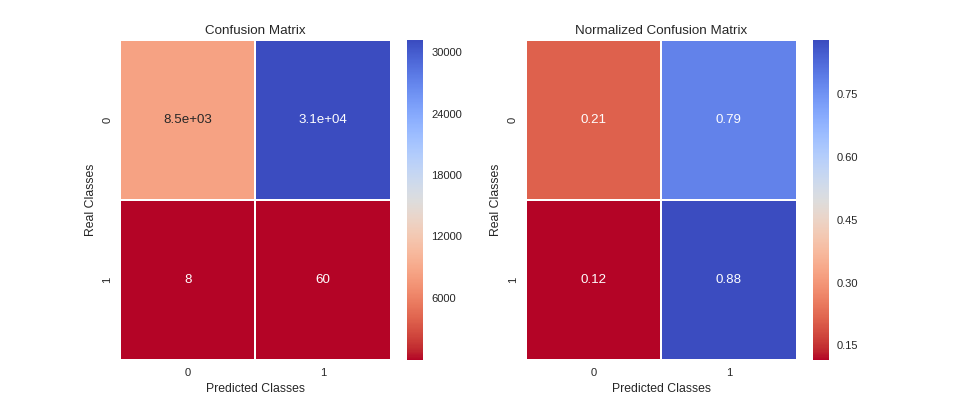

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      0.21      0.35     39805
          1       0.00      0.88      0.00        68

avg / total       1.00      0.21      0.35     39873



In [19]:
# MLP on ADASYN training data, SGD
mlp_adasyn = MLPClassifier(hidden_layer_sizes=(100,), max_iter=50,
                    solver='sgd', verbose=10, tol=1e-6, momentum=0.9,
                    learning_rate='adaptive', learning_rate_init=0.1)
mlp_adasyn.fit(dataset['X_train_'], dataset['y_train_'])
y_pred = mlp_adasyn.predict(dataset['X_test_'])
plot_confusion_matrix(dataset['y_test_'], y_pred)

### PRECISION RECALL CURVES

<IPython.core.display.Javascript object>


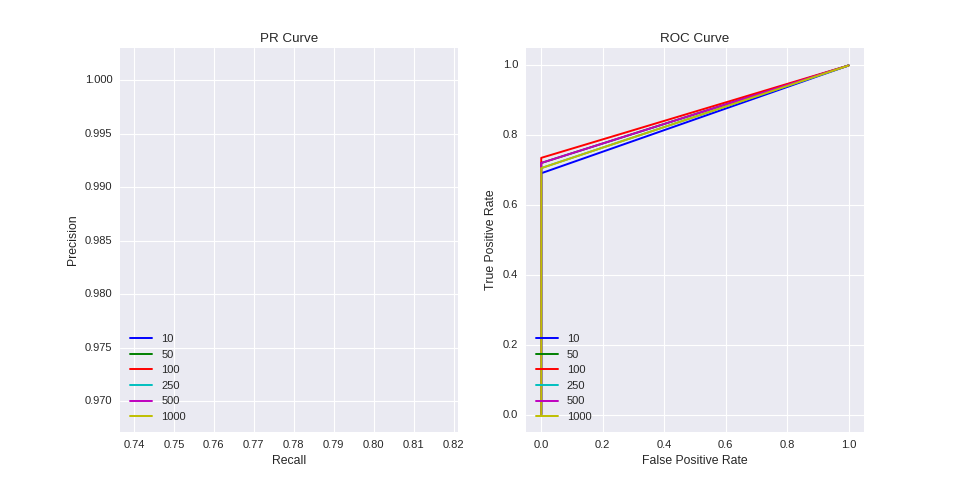

10
Iteration 1, loss = 0.02328592
Iteration 2, loss = 0.00445930
Iteration 3, loss = 0.00384488
Iteration 4, loss = 0.00363661
Iteration 5, loss = 0.00351536
Iteration 6, loss = 0.00341650
Iteration 7, loss = 0.00333910
Iteration 8, loss = 0.00328281
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Setting learning rate to 0.002000
Iteration 9, loss = 0.00322015
Iteration 10, loss = 0.00320954
Iteration 11, loss = 0.00319982
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Setting learning rate to 0.000400
Iteration 12, loss = 0.00318803
Iteration 13, loss = 0.00318599
Iteration 14, loss = 0.00318417
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Setting learning rate to 0.000080
Iteration 15, loss = 0.00318163
Iteration 16, loss = 0.00318127
Iteration 17, loss = 0.00318087
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Setting learning rate to 0.000016
It

In [7]:
# Unsampled training data # mlp_prec_recall_n_layer_unsampled_unweighted_sgd_0_01
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for n_l,k in zip([10, 50, 100, 250, 500, 1000],'bgrcmy'):
    print(n_l)
    mlp = MLPClassifier(hidden_layer_sizes=(n_l,), max_iter=50,
                    solver='sgd', verbose=10, tol=1e-4, momentum=0.9,
                    learning_rate='adaptive', learning_rate_init=0.01)
    mlp.fit(dataset['X_train'], dataset['y_train'])
    y_pred = mlp.predict(dataset['X_test'])

    p,r,_ = precision_recall_curve(dataset['y_test'], y_pred)
    tpr,fpr,_ = roc_curve(dataset['y_test'], y_pred)
    
    ax1.plot(r,p,c=k,label=n_l)
    ax2.plot(tpr,fpr,c=k,label=n_l)

ax1.legend(loc='lower left')
ax2.legend(loc='lower left')
plt.show()
# Conclusion:

<IPython.core.display.Javascript object>


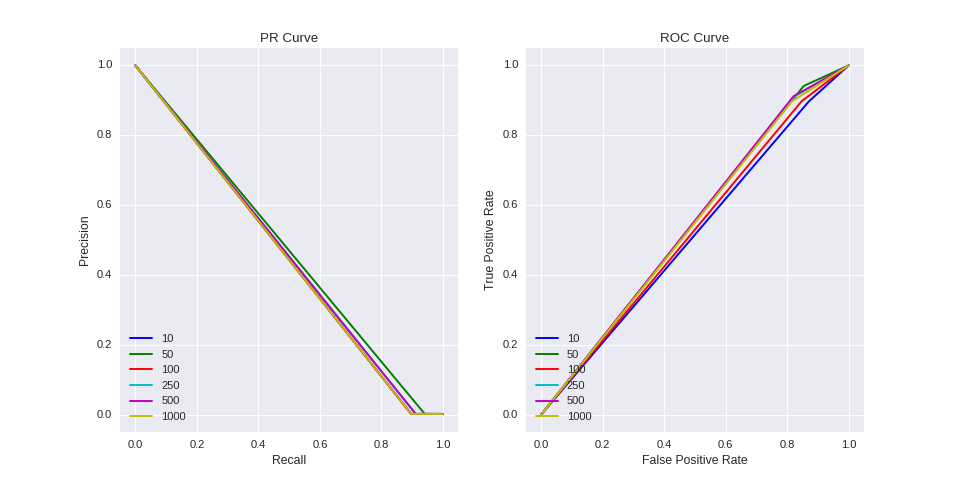

10
Iteration 1, loss = 0.10857806
Iteration 2, loss = 0.05849875
Iteration 3, loss = 0.04709598
Iteration 4, loss = 0.04159586
Iteration 5, loss = 0.03839253
Iteration 6, loss = 0.03614889
Iteration 7, loss = 0.03453508
Iteration 8, loss = 0.03338622
Iteration 9, loss = 0.03232343
Iteration 10, loss = 0.03121971
Iteration 11, loss = 0.03007816
Iteration 12, loss = 0.02884904
Iteration 13, loss = 0.02796457
Iteration 14, loss = 0.02734108
Iteration 15, loss = 0.02683491
Iteration 16, loss = 0.02639202
Iteration 17, loss = 0.02609376
Iteration 18, loss = 0.02561449
Iteration 19, loss = 0.02532945
Iteration 20, loss = 0.02502184
Iteration 21, loss = 0.02479446
Iteration 22, loss = 0.02451307
Iteration 23, loss = 0.02423317
Iteration 24, loss = 0.02394022
Iteration 25, loss = 0.02369553
Iteration 26, loss = 0.02347312
Iteration 27, loss = 0.02327789
Iteration 28, loss = 0.02305391
Iteration 29, loss = 0.02285266
Iteration 30, loss = 0.02258627
Iteration 31, loss = 0.02257847
Iteration 32, 

/home/yazan/.venvs/syde522/local/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Iteration 1, loss = 0.09546812
Iteration 2, loss = 0.05021565
Iteration 3, loss = 0.03806575
Iteration 4, loss = 0.03112572
Iteration 5, loss = 0.02686655
Iteration 6, loss = 0.02374498
Iteration 7, loss = 0.02124652
Iteration 8, loss = 0.01916112
Iteration 9, loss = 0.01745707
Iteration 10, loss = 0.01605265
Iteration 11, loss = 0.01496640
Iteration 12, loss = 0.01393268
Iteration 13, loss = 0.01300054
Iteration 14, loss = 0.01222379
Iteration 15, loss = 0.01167979
Iteration 16, loss = 0.01098502
Iteration 17, loss = 0.01041921
Iteration 18, loss = 0.00991616
Iteration 19, loss = 0.00950451
Iteration 20, loss = 0.00909830
Iteration 21, loss = 0.00870141
Iteration 22, loss = 0.00830621
Iteration 23, loss = 0.00794531
Iteration 24, loss = 0.00762009
Iteration 25, loss = 0.00734619
Iteration 26, loss = 0.00707538
Iteration 27, loss = 0.00683202
Iteration 28, loss = 0.00660078
Iteration 29, loss = 0.00641723
Iteration 30, loss = 0.00621243
Iteration 31, loss = 0.00603678
Iteration 32, los

In [8]:
# Unsampled training data # mlp_prec_recall_n_layer_adasyn_unweighted_sgd_0_01
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for n_l,k in zip([10, 50, 100, 250, 500, 1000],'bgrcmy'):
    print(n_l)
    mlp = MLPClassifier(hidden_layer_sizes=(n_l,), max_iter=50,
                    solver='sgd', verbose=10, tol=1e-4, momentum=0.9,
                    learning_rate='adaptive', learning_rate_init=0.01)
    mlp.fit(dataset['X_train_'], dataset['y_train_'])
    y_pred = mlp.predict(dataset['X_test_'])

    p,r,_ = precision_recall_curve(dataset['y_test_'], y_pred)
    tpr,fpr,_ = roc_curve(dataset['y_test_'], y_pred)
    
    ax1.plot(r,p,c=k,label=n_l)
    ax2.plot(tpr,fpr,c=k,label=n_l)

ax1.legend(loc='lower left')
ax2.legend(loc='lower left')
plt.show()
# Conclusion: